In [1]:
import pandas as pd
import os, sys, json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
root_dir = os.path.dirname(os.getcwd())
sys.path.append(root_dir)

In [2]:

metadataset_df = pd.read_csv(f"{root_dir}/TabZilla/tutorials/metadataset_clean_andreas.csv")

def read_json(file):
    with open(file, "r") as f:
        return json.load(f)
    
eval = {}

model_dict = {
    'tabpfn': 'TabPFNModel',
    'tabsmall': 'TabSmallModel',
}


In [3]:
def get_datasets(table_idx):
    if table_idx == 1:
        from analysis.table1 import DATASETS
    elif table_idx == 2:
        from analysis.table2 import DATASETS
    elif table_idx == 4:
        from analysis.table4 import DATASETS
        
    return DATASETS

In [4]:
def get_dataset_stat(dataset):
    result_dir = f"{root_dir}/results/TabFlexModel/{dataset}"
    items = os.listdir(result_dir)
    for item in items:
        if item == 'default_trial0_results.json':
            result = read_json(f"{result_dir}/{item}")
            break
        elif os.path.isdir(f"{result_dir}/{item}"):
            result = read_json(f"{result_dir}/{item}/default_trial0_results.json")
            break
    return {
        'num_classes': result['dataset']['num_classes'],
        'num_features': result['dataset']['num_features'],
        'num_instances': result['dataset']['num_instances'],
    }

In [5]:
def get_results(dataset, model, metric = 'Accuracy'):
    result_dir = f"{root_dir}/results/{model_dict[model]}/{dataset}"
    items = os.listdir(result_dir)
    
    best_eval = None
    for item in items: 
        try:
            if item == 'default_trial0_results.json':
                eval = read_json(f"{result_dir}/{item}")
                if best_eval is None or eval['scorers']['test'][metric] > best_eval['scorers']['test'][metric]:
                    best_eval = eval
            elif os.path.isdir(f"{result_dir}/{item}"):
                eval = read_json(f"{result_dir}/{item}/default_trial0_results.json")
                if best_eval is None or eval['scorers']['test'][metric] > best_eval['scorers']['test'][metric]:
                    best_eval = eval
        except KeyboardInterrupt:
            raise KeyboardInterrupt
        except Exception as e:
            # print the error message
            print(e)
            print(f"Error reading {result_dir}/{item}")
                  
    return best_eval

In [6]:
def get_tabmodels(method, eval, raw_results, metric = 'Accuracy'):
    eval[method] = {}
    for dataset in raw_results[method]:
        eval[method][dataset] = {}
        metrics = raw_results[method][dataset]['scorers']['test'][metric]
        metrics = pd.Series(metrics)
        eval[method][dataset][f'median_{metric}'] = metrics.median()
        eval[method][dataset][f'mean_{metric}'] = metrics.mean()
        eval[method][dataset]['train_time'] = pd.Series(raw_results[method][dataset]['timers']['train'][1:]).mean()
        eval[method][dataset]['test_time'] = pd.Series(raw_results[method][dataset]['timers']['test']).mean()
        eval[method][dataset]['total_time'] = eval[method][dataset]['train_time'] + eval[method][dataset]['test_time']
    

In [27]:
table_idx = 2
metric = 'Accuracy'

DATASETS = get_datasets(table_idx)
raw_results = {}

tqdm_bar = tqdm(model_dict)
for model in tqdm_bar:
    tqdm_bar.set_description(f"Reading results of {model}...")
    raw_results[model] = {}
    for dataset in DATASETS:
        raw_results[model][dataset] = get_results(dataset, model, metric = metric)            
        
tqdm_bar = tqdm(model_dict)
for model in tqdm_bar:
    tqdm_bar.set_description(f"Computing results of {model}...")
    get_tabmodels(model, eval, raw_results, metric)

Computing results of tabsmall...: 100%|██████████| 2/2 [00:00<00:00, 58.43it/s]


In [28]:
table_dict = {}

for dataset in DATASETS:
    table_dict[dataset] = get_dataset_stat(dataset)
    for method in model_dict:
        table_dict[dataset][f'{method}_{metric}'] = round(eval[method][dataset][f'mean_{metric}'], 4)
        table_dict[dataset][f'{method}_time'] = round(eval[method][dataset]['total_time'], 4)
        
table = pd.DataFrame(table_dict).T

In [29]:
# legend_converter = {
#     'tabsmall': ('>', '-', "#8884D8", 'Linear Attention'),
#     'tabpfn': ('o', '--', "#82CA9D", 'Softmax Attention'),
# }

legend_converter = {
    'tabsmall': ('>', '-', '#073B4C', 'Linear Attention'),
    'tabpfn': ('o', '--', '#DD3497', 'Softmax Attention'),
}

/tmp/ipykernel_2914123/795105193.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xy=(table[f'{method2}_time'][i], table[f'{method2}_{metric}'][i]),
/tmp/ipykernel_2914123/795105193.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xytext=(table[f'{method1}_time'][i], table[f'{method1}_{metric}'][i]),


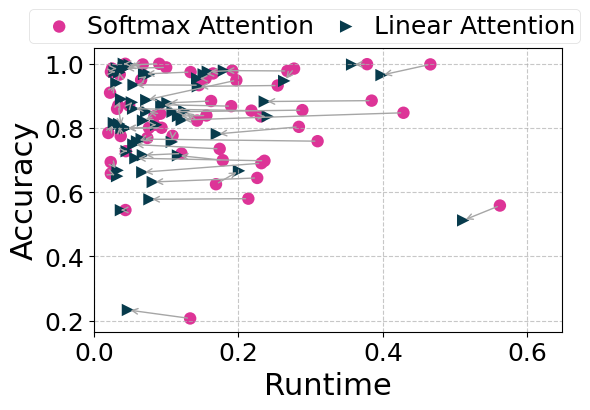

In [30]:
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

lw = 3
markersize = 80
arrow_color = '#a6a6a6'
arrow_linewidth = 1
arrow_alpha = 1

fig, ax = plt.subplots(figsize=(6, 4))
fig.subplots_adjust(left=0.17, right=0.95, top=0.89, bottom=0.18)

for method in model_dict:
    ax.scatter(
        table[f'{method}_time'],
        table[f'{method}_{metric}'], 
        label=legend_converter[method][3], 
        marker=legend_converter[method][0],
        s=markersize, 
        color=legend_converter[method][2],
        edgecolors='none'
    )

method1 = 'tabpfn'
method2 = 'tabsmall'
for i in range(len(table)):
    ax.annotate('',
                xy=(table[f'{method2}_time'][i], table[f'{method2}_{metric}'][i]),
                xytext=(table[f'{method1}_time'][i], table[f'{method1}_{metric}'][i]),
                arrowprops=dict(arrowstyle='->', color=arrow_color, 
                                linewidth=arrow_linewidth, alpha=arrow_alpha))

# Customize the plot
ax.set_xlabel('Runtime', fontsize=22)
ax.set_ylabel(metric.capitalize(), fontsize=22)
ax.grid(True, linestyle='--', alpha=0.7)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# Adjust tick parameters
ax.tick_params(axis='both', which='major', labelsize=18)

# Set axis limits with some padding
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
ax.set_xlim(0, x_max * 1.1)
ax.set_ylim(y_min * 0.99, y_max * 1.01)

legend = ax.legend(
    fontsize=18, 
    loc = 'upper center',
    bbox_to_anchor=(.45,1.18), 
    handletextpad=0.1,
    frameon=True,  
    ncols=2,
    columnspacing=0.3,
    borderpad=0.2,  # Adjusts padding between legend edge and content
    labelspacing=0.5  # Adjusts vertical space between legend entries
)
# Legend
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('lightgray')
plt.savefig(f'{root_dir}/figures/linear_improvement.pdf')